In [2]:
import tqdm as notebook_tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path

DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
NUM_CLASSES = 6  # num classes for classification
BATCH_SIZE = 64
EPOCHS = 10
LR = 0.001
NUM_FOLDS = 5
MAX_SEQ_LENGTH = 70

notebook_dir = Path.cwd()
BASE_DIR = notebook_dir.parent

DATA_PATH = BASE_DIR / "data" / "aufgabe3"
DATA_PATH_FOLDS = DATA_PATH / "5-fold"
MODEL_SAVE_PATH_TEMP = str(BASE_DIR / "models" / "6state_vhse_lstm_cnn_fold{}.pt")
MODEL_SAVE_PATH = BASE_DIR / "models" / "6state_vhse_lstm_cnn.pt"
TRAIN_VAL_LOSSES_DATA_SAVE_PATH = DATA_PATH / "outputs"
TEST_CSV = DATA_PATH / "reduced_30_signalP6_test.csv"

(BASE_DIR / "models").mkdir(exist_ok=True)
(DATA_PATH / "outputs").mkdir(exist_ok=True)

print(f"Project base directory set to: {BASE_DIR}")
print(f"Data path set to: {DATA_PATH}")
print(f"Model save path set to: {MODEL_SAVE_PATH}")

# One-hot encoding setup (from 2-state model)
aas = 'ARNDCEQGHILKMFPSTWYV'
aa2idx = {aa: i for i, aa in enumerate(aas)}
idx2aa = {i: aa for aa, i in aa2idx.items()}
num_aa = len(aas)
print(f"Number of amino acids: {num_aa}")

Using device: mps
Project base directory set to: /Users/jonas/Desktop/Uni/PBL/sp-prediction
Data path set to: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3
Model save path set to: /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn.pt
Number of amino acids: 20


In [3]:

print("Loading test data...")
test_df = pd.read_csv(TEST_CSV)
print(f"Test records: {len(test_df)}")

test_df.head()


Loading test data...
Test records: 3419


,uniprot_id,kingdom,type,sequence,labels,length,has_sp
0,B2VGX7,NEGATIVE,TAT,MKAVNPLTENDVTPESLFNARRRTVLKMLGMSAAALSLPGAARADL...,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTOO...,70,True
1,Q9DEN4,EUKARYA,NO_SP,MTLSGSGSASDMSGQTVLSADDADIDVVGEGDEALDKDSECESTAG...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,70,False
2,A9QM74,EUKARYA,NO_SP,MPTLDAPEERRRKFKYRGKDVSLRRQQRMAVSLELRKAKKDEQTLK...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,70,False
3,Q8K3I4,EUKARYA,NO_SP,MGRKLDLSGLTDDETEHVLQVVQRDFNLRKKEEDRLSEMKQRLAEE...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,70,False
4,Q920M2,EUKARYA,NO_SP,MEVPELGPGLVERLEQLATCPLCGGPFEDPVLLACEHSFCRSCLAR...,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...,70,False


In [4]:
label_map = {'S': 0, 'T': 1, 'L': 2, 'I': 3, 'M': 4, 'O': 5}

num_vhse_features = 8
vhse_dict = {
    'A': [0.15, -1.11, -1.35, -0.92, 0.02, -0.91, 0.36, -0.48],
    'R': [-1.47, 1.45, 1.24, 1.27, 1.55, 1.47, 1.30, 0.83],
    'N': [-0.99, 0.00, -0.37, 0.69, -0.55, 0.85, 0.73, -0.80],
    'D': [-1.15, 0.67, -0.41, -0.01, -2.68, 1.31, 0.03, 0.56],
    'C': [0.18, -1.67, -0.46, -0.21, 0.00, 1.20, -1.61, -0.19],
    'Q': [-0.96, 0.12, 0.18, 0.16, 0.09, 0.42, -0.20, -0.41],
    'E': [-1.18, 0.40, 0.10, 0.36, -2.16, -0.17, 0.91, 0.02],
    'G': [-0.20, -1.53, -2.63, 2.28, -0.53, -1.18, 2.01, -1.34],
    'H': [-0.43, -0.25, 0.37, 0.19, 0.51, 1.28, 0.93, 0.65],
    'I': [1.27, -0.14, 0.30, -1.80, 0.30, -1.61, -0.16, -0.13],
    'L': [1.36, 0.07, 0.26, -0.80, 0.22, -1.37, 0.08, -0.62],
    'K': [-1.17, 0.70, 0.70, 0.80, 1.64, 0.67, 1.63, 0.13],
    'M': [1.01, -0.53, 0.43, 0.00, 0.23, 0.10, -0.86, -0.68],
    'F': [1.52, 0.61, 0.96, -0.16, 0.25, 0.28, -1.33, -0.20],
    'P': [0.22, -0.17, -0.50, 0.05, -0.01, -1.34, -0.19, 3.56],
    'S': [-0.67, -0.86, -1.07, -0.41, -0.32, 0.27, -0.64, 0.11],
    'T': [-0.34, -0.51, -0.55, -1.06, -0.06, -0.01, -0.79, 0.39],
    'W': [1.50, 2.06, 1.79, 0.75, 0.75, -0.13, -1.01, -0.85],
    'Y': [0.61, 1.60, 1.17, 0.73, 0.53, 0.25, -0.96, -0.52],
    'V': [0.76, -0.92, -0.17, -1.91, 0.22, -1.40, -0.24, -0.03]
}


def vhse_encode_sequence(sequence, max_length=MAX_SEQ_LENGTH):
    encoding = np.zeros((max_length, num_vhse_features), dtype=np.float32)
    
    for i, aa in enumerate(sequence):
        if i >= max_length:
            break
        if aa in vhse_dict:
            encoding[i] = vhse_dict[aa]
        # Unknown amino acids remain as zero vectors
    
    return encoding

print("\nProcessing test data...")
test_df_filtered = test_df[~test_df["labels"].str.contains("P", na=False)]
print(f"Test records after filtering: {len(test_df_filtered)}")

test_df_filtered.describe()

test_df_encoded = test_df_filtered.copy()
test_df_encoded["label"] = test_df_encoded["labels"].apply(lambda x: [label_map[c] for c in x if c in label_map])
test_df_encoded = test_df_encoded[test_df_encoded["label"].map(len) > 0]
test_seqs = test_df_encoded["sequence"].tolist()
test_label_seqs = test_df_encoded["label"].tolist()

print(f"Test sequences: {len(test_seqs)}")
print(f"VHSE encoding shape: ({MAX_SEQ_LENGTH}, {num_vhse_features})")
test_df_encoded.describe()


Processing test data...
Test records after filtering: 3412
Test sequences: 3412
VHSE encoding shape: (70, 8)


,length
count,3412.0
mean,70.0
std,0.0
min,70.0
25%,70.0
50%,70.0
75%,70.0
max,70.0


In [5]:
class SPDataset(Dataset):
    def __init__(self, sequences, label_seqs, label_map):
        self.label_map = label_map
        self.label_seqs = label_seqs
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        labels = self.label_seqs[idx]
        
        # One-hot encode the sequence
        encoded_seq = vhse_encode_sequence(seq, MAX_SEQ_LENGTH)
        
        # Create attention mask (1 for actual sequence, 0 for padding)
        attention_mask = np.zeros(MAX_SEQ_LENGTH, dtype=np.float32)
        seq_len = min(len(seq), MAX_SEQ_LENGTH)
        attention_mask[:seq_len] = 1.0
        
        # Pad or truncate labels to match MAX_SEQ_LENGTH
        token_labels = np.full(MAX_SEQ_LENGTH, -100, dtype=np.int64)
        for i, label in enumerate(labels):
            if i >= MAX_SEQ_LENGTH:
                break
            token_labels[i] = label
        
        return {
            'encoded_seq': torch.tensor(encoded_seq, dtype=torch.float32),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.float32),
            'labels': torch.tensor(token_labels, dtype=torch.long)
        }

# Test dataset
test_dataset = SPDataset(test_seqs, test_label_seqs, label_map)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nTest data prepared: {len(test_seqs)} sequences")
print(f"VHSE encoding shape: ({MAX_SEQ_LENGTH}, {num_vhse_features})")


Test data prepared: 3412 sequences
VHSE encoding shape: (70, 8)


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchcrf import CRF

class SPCNNClassifier(nn.Module):
    def __init__(self, num_features, num_labels, hidden_dim=512):
        super().__init__()
        self.num_features = num_features
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.35)
        
        # Input: one-hot encoded sequences (batch, seq_len, num_features=8)
        # Need to project to higher dimension for CNN
        self.input_projection = nn.Linear(num_features, hidden_dim)
        
        # CNN layer (similar to original but adjusted for smaller input)
        self.conv = nn.Conv1d(in_channels=hidden_dim, out_channels=1024, kernel_size=5, padding=2)
        self.bn_conv = nn.BatchNorm1d(1024)
        
        # BiLSTM
        self.lstm = nn.LSTM(input_size=1024, hidden_size=512, num_layers=2, bidirectional=True, batch_first=True)
        
        # Classifier
        self.classifier = nn.Linear(512 * 2, num_labels)
        
        # CRF
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, encoded_seq, attention_mask, labels=None):
        # encoded_seq: (batch, seq_len, num_aa)
        batch_size = encoded_seq.size(0)
        
        # Project one-hot encoding to higher dimension
        x = self.input_projection(encoded_seq)  # (batch, seq_len, hidden_dim)
        
        # Apply conv (requires channels first)
        x_conv = self.conv(x.transpose(1, 2))  # (batch, 1024, seq_len)
        x_conv = self.bn_conv(x_conv)
        x_conv = F.relu_(x_conv)
        
        # Transpose for LSTM
        x_lstm_input = x_conv.transpose(1, 2)  # (batch, seq_len, 1024)
        
        # Apply LSTM
        lstm_out, _ = self.lstm(x_lstm_input)  # (batch, seq_len, 1024)
        
        # Classifier
        x_linear = self.classifier(lstm_out)  # (batch, seq_len, num_labels)
        logits = self.dropout(x_linear)
        
        if labels is not None:
            # Create CRF mask
            crf_mask = (labels != -100) & (attention_mask.bool())
            
            # Replace -100 with 0 for CRF compatibility
            mod_labels = labels.clone()
            mod_labels[labels == -100] = 0
            
            loss = -self.crf(logits, mod_labels, mask=crf_mask, reduction='mean')
            return loss
        else:
            # Decode only valid positions
            crf_mask = attention_mask.bool()
            predictions = self.crf.decode(logits, mask=crf_mask)
            return predictions

print("\nModel architecture:")
print(f"  Input: VHSE encoded sequences ({MAX_SEQ_LENGTH}, {num_vhse_features})")
print(f"  Projection: {num_vhse_features} → 512")
print(f"  CNN: 512 → 1024 (kernel=5)")
print(f"  BiLSTM: 1024 → 512×2 (2 layers)")
print(f"  Classifier: 1024 → {NUM_CLASSES}")
print(f"  CRF: {NUM_CLASSES} states")


Model architecture:
  Input: VHSE encoded sequences (70, 8)
  Projection: 8 → 512
  CNN: 512 → 1024 (kernel=5)
  BiLSTM: 1024 → 512×2 (2 layers)
  Classifier: 1024 → 6
  CRF: 6 states


In [7]:
from transformers import get_linear_schedule_with_warmup

# load and prepare data for a specific fold
def prepare_fold_data(fold_num):

    train_csv = os.path.join(DATA_PATH_FOLDS, f"fold_{fold_num}_train.csv")
    val_csv = os.path.join(DATA_PATH_FOLDS, f"fold_{fold_num}_val.csv")

    print(f"\n=== Fold {fold_num} ===")
    print(f"Loading training data from: {train_csv}")
    train_df = pd.read_csv(train_csv)
    print(f"Training records: {len(train_df)}")
    print(train_df['type'].value_counts())

    print(f"Loading validation data from: {val_csv}")
    val_df = pd.read_csv(val_csv)
    print(f"Validation records: {len(val_df)}")

    # Filter data
    train_df_filtered = train_df[~train_df["labels"].str.contains("P", na=False)]
    val_df_filtered = val_df[~val_df["labels"].str.contains("P", na=False)]
    print(f"Training records after filtering: {len(train_df_filtered)}")
    print(f"Validation records after filtering: {len(val_df_filtered)}")

    # Encode labels
    train_df_encoded = train_df_filtered.copy()
    train_df_encoded["label"] = train_df_encoded["labels"].apply(lambda x: [label_map[c] for c in x if c in label_map])
    train_df_encoded = train_df_encoded[train_df_encoded["label"].map(len) > 0]
    train_seqs = train_df_encoded["sequence"].tolist()
    train_label_seqs = train_df_encoded["label"].tolist()
    print("Encoded train data:")
    train_df_encoded.head()

    val_df_encoded = val_df_filtered.copy()
    val_df_encoded["label"] = val_df_encoded["labels"].apply(lambda x: [label_map[c] for c in x if c in label_map])
    val_df_encoded = val_df_encoded[val_df_encoded["label"].map(len) > 0]
    val_seqs = val_df_encoded["sequence"].tolist()
    val_label_seqs = val_df_encoded["label"].tolist()

    # Create datasets
    train_dataset = SPDataset(train_seqs, train_label_seqs, label_map)
    val_dataset = SPDataset(val_seqs, val_label_seqs, label_map)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Fold {fold_num} prepared: {len(train_seqs)} train, {len(val_seqs)} val sequences")

    return train_loader, val_loader, train_seqs, val_seqs

/Users/jonas/Desktop/Uni/PBL/sp-prediction/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# sequence-level accuracy, skipping -100 (ignored) positions
def sequence_level_accuracy(preds_flat, labels_flat, test_label_seqs):
    # reconstruct the sequences from the flat predictions
    seq_lengths = [len(seq) for seq in test_label_seqs]
    preds_seq = []
    labels_seq = []
    idx = 0
    for l in seq_lengths:
        preds_seq.append(preds_flat[idx:idx+l])
        labels_seq.append(labels_flat[idx:idx+l])
        idx += l

    # check if the valid predictions match the labels
    correct = 0
    for pred, label in zip(preds_seq, labels_seq):
        is_valid = [l != -100 for l in label]
        valid_preds = [p for p, valid in zip(pred, is_valid) if valid]
        valid_labels = [l for l, valid in zip(label, is_valid) if valid]
        if valid_preds == valid_labels:
            correct += 1

    total = len(seq_lengths)
    return correct / total if total > 0 else 0.0


def sequence_level_accuracy_only_sps(preds_flat, labels_flat, label_seqs):
    """
    Calculate sequence-level accuracy only for sequences that contain signal peptides.
    SP labels: S=0 (n-region), T=1 (h-region), L=2 (c-region)
    """
    # Reconstruct sequences from flat predictions
    seq_lengths = [len(seq) for seq in label_seqs]
    preds_seq = []
    labels_seq = []
    idx = 0
    for length in seq_lengths:
        preds_seq.append(preds_flat[idx : idx + length])
        labels_seq.append(labels_flat[idx : idx + length])
        idx += length

    # Check if valid predictions match labels, only for sequences with signal peptides
    correct = 0
    total_sp_sequences = 0
    for pred, label in zip(preds_seq, labels_seq):
        is_valid = [lbl != -100 for lbl in label]
        valid_labels = [lbl for lbl, valid in zip(label, is_valid) if valid]

        # Only consider sequences that have SP labels (0=S/n-region, 1=T/h-region, 2=L/c-region)
        has_sp = any(lbl in (0, 1, 2) for lbl in valid_labels)
        if not has_sp:
            continue

        total_sp_sequences += 1
        valid_preds = [p for p, valid in zip(pred, is_valid) if valid]
        if valid_preds == valid_labels:
            correct += 1

    return correct / total_sp_sequences if total_sp_sequences > 0 else 0.0

In [9]:
# Count model parameters
def count_parameters(model):
    """Count total and trainable parameters in the model"""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\n{'='*60}")
    print("MODEL PARAMETER COUNT")
    print(f"{'='*60}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {total_params - trainable_params:,}")
    print(f"{'='*60}\n")
    
    return total_params, trainable_params

# Create a model instance and count parameters
model_temp = SPCNNClassifier(num_vhse_features, NUM_CLASSES).to(DEVICE)

total, trainable = count_parameters(model_temp)


MODEL PARAMETER COUNT
Total parameters: 15,234,614
Trainable parameters: 15,234,614
Non-trainable parameters: 0



In [ ]:
from tqdm import tqdm
from torch.amp import autocast, GradScaler
from sklearn.metrics import matthews_corrcoef, accuracy_score
import gc
import matplotlib.pyplot as plt
import pickle

# Store results for all folds
fold_results = {
    'train_losses': [],
    'val_losses': [],
    'val_mcc': [],
    'val_seq_acc': [],
    'val_seq_accs_only_sps': [],
    'best_val_losses': [],
    'best_metrics': [],
    'fold_numbers': []
}

# Cross Validation Training Loop
for fold in range(1, NUM_FOLDS + 1):
    print(f"\n{'='*60}")
    print(f"Starting Fold {fold}/{NUM_FOLDS}")
    print(f"{'='*60}")

    # Prepare data for this fold
    train_loader, val_loader, train_seqs, val_seqs = prepare_fold_data(fold)
    
    # Get val_label_seqs for sequence-level accuracy
    val_csv = os.path.join(DATA_PATH_FOLDS, f"fold_{fold}_val.csv")
    val_df_temp = pd.read_csv(val_csv)
    val_df_temp = val_df_temp[~val_df_temp["labels"].str.contains("P", na=False)]
    val_df_temp["label"] = val_df_temp["labels"].apply(lambda x: [label_map[c] for c in x if c in label_map])
    val_df_temp = val_df_temp[val_df_temp["label"].map(len) > 0]
    val_label_seqs = val_df_temp["label"].tolist()

    # Initialize fresh model for each fold (no encoder to unfreeze!)
    model = SPCNNClassifier(num_vhse_features, NUM_CLASSES).to(DEVICE)

    # Optimizer - all layers train from the start
    optimizer = torch.optim.AdamW([
        {"params": model.input_projection.parameters(), "lr": 1e-3},
        {"params": model.conv.parameters(), "lr": 1e-3},
        {"params": model.classifier.parameters(), "lr": 1e-3},
        {"params": model.lstm.parameters(), "lr": 1e-3},
        {"params": model.crf.parameters(), "lr": 1e-3},
    ])

    scaler = GradScaler()

    # Track losses and metrics for this fold
    train_losses = []
    val_losses = []
    val_mccs = []
    val_seq_accs = []
    val_seq_accs_only_sps = []
    best_val_loss = float('inf')
    best_fold_metrics = None
    patience = 4
    patience_counter = 0

    # Training loop for this fold
    for epoch in range(EPOCHS):

        # Create scheduler for epoch
        total_steps = len(train_loader)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps
        )

        # Training phase
        model.train()
        pbar = tqdm(train_loader, desc=f"Fold {fold} - Epoch {epoch+1}/{EPOCHS} [Train]", unit="batch")
        total_train_loss = 0

        for batch in pbar:
            try:
                encoded_seq = batch['encoded_seq'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                token_labels = batch['labels'].to(DEVICE)

                optimizer.zero_grad()

                loss = model(encoded_seq, attention_mask, token_labels)

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()

                total_train_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

            except RuntimeError as e:
                print("Error during training:", e)
                gc.collect()
                continue

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase with full metrics
        model.eval()
        total_val_loss = 0
        val_batches = 0
        all_val_preds = []
        all_val_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Fold {fold} - Epoch {epoch+1}/{EPOCHS} [Val]", unit="batch"):
                encoded_seq = batch['encoded_seq'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                token_labels = batch['labels'].to(DEVICE)

                loss = model(encoded_seq, attention_mask, token_labels)
                total_val_loss += loss.item()
                val_batches += 1
                
                # Get predictions for metrics
                predictions = model(encoded_seq, attention_mask)
                
                # Collect valid tokens
                for pred_seq, label_seq, mask in zip(predictions, token_labels, attention_mask):
                    for pred, true, is_valid in zip(pred_seq, label_seq, mask):
                        if true.item() != -100 and is_valid.item() == 1:
                            all_val_preds.append(pred)
                            all_val_labels.append(true.item())

        avg_val_loss = total_val_loss / val_batches if val_batches > 0 else 0
        val_losses.append(avg_val_loss)
        
        # Calculate validation metrics
        epoch_mcc = matthews_corrcoef(all_val_labels, all_val_preds)
        epoch_seq_acc = sequence_level_accuracy(all_val_preds, all_val_labels, val_label_seqs)
        epoch_seq_acc_only_sps = sequence_level_accuracy_only_sps(all_val_preds, all_val_labels, val_label_seqs)
        
        val_mccs.append(epoch_mcc)
        val_seq_accs.append(epoch_seq_acc)
        val_seq_accs_only_sps.append(epoch_seq_acc_only_sps)

        print(f"Fold {fold} - Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, MCC: {epoch_mcc:.4f}, SeqAcc: {epoch_seq_acc:.4f}, SeqAcc(SP): {epoch_seq_acc_only_sps:.4f}")

        # Save best model for fold (temporary)
        if avg_val_loss < best_val_loss:
            patience_counter = 0
            best_val_loss = avg_val_loss
            best_fold_metrics = {
                'mcc': epoch_mcc,
                'seq_acc': epoch_seq_acc,
                'seq_acc_only_sps': epoch_seq_acc_only_sps,
                'token_acc': accuracy_score(all_val_labels, all_val_preds),
            }
            model_path_temp = MODEL_SAVE_PATH_TEMP.format(fold)
            torch.save(model.state_dict(), model_path_temp)
            print(f"  → Best model for fold {fold} saved to {model_path_temp}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} for fold {fold}")
                break

    # Store results for fold
    fold_results['train_losses'].append(train_losses)
    fold_results['val_losses'].append(val_losses)
    fold_results['val_mcc'].append(val_mccs)
    fold_results['val_seq_acc'].append(val_seq_accs)
    fold_results['val_seq_accs_only_sps'].append(val_seq_accs_only_sps)
    fold_results['best_val_losses'].append(best_val_loss)
    fold_results['best_metrics'].append(best_fold_metrics)
    fold_results['fold_numbers'].append(fold)

    print(f"\nBest validation loss for fold {fold}: {best_val_loss:.4f}")
    print(f"Best metrics: MCC={best_fold_metrics['mcc']:.4f}, SeqAcc={best_fold_metrics['seq_acc']:.4f}, SeqAcc(SP)={best_fold_metrics['seq_acc_only_sps']:.4f}")


print("\n" + "="*60)
print("K-Fold Cross Validation Complete!")
print("="*60)

print("\nSummary of all folds:")
for i, (best_loss, metrics) in enumerate(zip(fold_results['best_val_losses'], fold_results['best_metrics']), 1):
    print(f"Fold {i}: Loss={best_loss:.4f}, MCC={metrics['mcc']:.4f}, SeqAcc={metrics['seq_acc']:.4f}, SeqAcc(SP)={metrics['seq_acc_only_sps']:.4f}")

avg_best_val_loss = sum(fold_results['best_val_losses']) / NUM_FOLDS
avg_mcc = np.mean([m['mcc'] for m in fold_results['best_metrics']])
avg_seq_acc = np.mean([m['seq_acc'] for m in fold_results['best_metrics']])
avg_seq_acc_only_sps = np.mean([m['seq_acc_only_sps'] for m in fold_results['best_metrics']])

print(f"\nAverage across all folds:")
print(f"  Validation Loss: {avg_best_val_loss:.4f}")
print(f"  MCC: {avg_mcc:.4f} ± {np.std([m['mcc'] for m in fold_results['best_metrics']]):.4f}")
print(f"  Seq Accuracy: {avg_seq_acc:.4f} ± {np.std([m['seq_acc'] for m in fold_results['best_metrics']]):.4f}")
print(f"  Seq Accuracy (SP): {avg_seq_acc_only_sps:.4f} ± {np.std([m['seq_acc_only_sps'] for m in fold_results['best_metrics']]):.4f}")

# Find best fold
best_fold_idx = fold_results['best_val_losses'].index(min(fold_results['best_val_losses']))
best_fold_num = fold_results['fold_numbers'][best_fold_idx]
best_fold_loss = fold_results['best_val_losses'][best_fold_idx]

print(f"\n{'='*60}")
print(f"Best performing fold: Fold {best_fold_num}")
print(f"Best validation loss: {best_fold_loss:.4f}")
print(f"{'='*60}")

# best model saved to MODEL_SAVE_PATH
import shutil
best_model_path = MODEL_SAVE_PATH_TEMP.format(best_fold_num)
shutil.copy(best_model_path, MODEL_SAVE_PATH)
print(f"\nBest model (Fold {best_fold_num}) saved to: {MODEL_SAVE_PATH}")

# clean up of temporary fold models
print("\nTemporary fold models:")
for i in range(1, NUM_FOLDS + 1):
    temp_path = MODEL_SAVE_PATH_TEMP.format(i)
    if os.path.exists(temp_path):
        print(f"  - {temp_path}")

os.makedirs(TRAIN_VAL_LOSSES_DATA_SAVE_PATH, exist_ok=True)
losses_pickle_path = os.path.join(TRAIN_VAL_LOSSES_DATA_SAVE_PATH, "train_val_losses_vhse.pkl")

losses_data = {
    'fold_numbers': fold_results['fold_numbers'],
    'train_losses': fold_results['train_losses'],
    'val_losses': fold_results['val_losses'],
    'val_mcc': fold_results['val_mcc'],
    'val_seq_acc': fold_results['val_seq_acc'],
    'val_seq_accs_only_sps': fold_results['val_seq_accs_only_sps'],
    'best_val_losses': fold_results['best_val_losses'],
    'best_metrics': fold_results['best_metrics'],
    'best_fold_num': best_fold_num,
    'best_fold_loss': best_fold_loss,
    'avg_best_val_loss': avg_best_val_loss,
    'epochs': EPOCHS,
    'num_folds': NUM_FOLDS
}

with open(losses_pickle_path, 'wb') as f:
    pickle.dump(losses_data, f)

print(f"\nTraining and validation losses saved to: {losses_pickle_path}")
print(f"Data structure:")
print(f"  - fold_numbers: list of fold IDs")
print(f"  - train_losses: list of training losses per fold")
print(f"  - val_losses: list of validation losses per fold")
print(f"  - val_mcc: list of validation MCC per fold per epoch")
print(f"  - val_seq_acc: list of validation sequence accuracy per fold per epoch")
print(f"  - val_seq_accs_only_sps: list of validation SP sequence accuracy per fold per epoch")
print(f"  - best_metrics: list of best metrics dict for each fold")
print(f"  - best_fold_num: {best_fold_num}")
print(f"  - best_fold_loss: {best_fold_loss:.4f}")


Starting Fold 1/5

=== Fold 1 ===
Loading training data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_1_train.csv
Training records: 10940
type
NO_SP      9082
SP         1295
LIPO        424
TAT         103
PILIN        24
TATLIPO      12
Name: count, dtype: int64
Loading validation data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_1_val.csv
Validation records: 2735
Training records after filtering: 10916
Validation records after filtering: 2732
Encoded train data:
Fold 1 prepared: 10916 train, 2732 val sequences


/var/folders/ld/_1vh76bj5597tgzpl600cczc0000gn/T/ipykernel_60154/3360691576.py:36: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  scaler = GradScaler()
Fold 1 - Epoch 1/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 13.11batch/s]


Fold 1 - Epoch 1/10 - Train Loss: 46.6531, Val Loss: 13.7902
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold1.pt


Fold 1 - Epoch 2/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.15batch/s]


Fold 1 - Epoch 2/10 - Train Loss: 32.0959, Val Loss: 10.9972
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold1.pt


Fold 1 - Epoch 3/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.95batch/s]


Fold 1 - Epoch 3/10 - Train Loss: 26.5573, Val Loss: 9.6623
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold1.pt


Fold 1 - Epoch 4/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.96batch/s]


Fold 1 - Epoch 4/10 - Train Loss: 22.4399, Val Loss: 8.3294
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold1.pt


Fold 1 - Epoch 5/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.95batch/s]


Fold 1 - Epoch 5/10 - Train Loss: 18.9148, Val Loss: 7.6868
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold1.pt


Fold 1 - Epoch 6/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.82batch/s]


Fold 1 - Epoch 6/10 - Train Loss: 15.7859, Val Loss: 7.2885
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold1.pt


Fold 1 - Epoch 7/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.86batch/s]


Fold 1 - Epoch 7/10 - Train Loss: 13.2839, Val Loss: 6.4736
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold1.pt


Fold 1 - Epoch 8/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.81batch/s]


Fold 1 - Epoch 8/10 - Train Loss: 11.2990, Val Loss: 6.2815
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold1.pt


Fold 1 - Epoch 9/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.73batch/s]


Fold 1 - Epoch 9/10 - Train Loss: 9.7711, Val Loss: 5.6347
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold1.pt


Fold 1 - Epoch 10/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.69batch/s]


Fold 1 - Epoch 10/10 - Train Loss: 8.3065, Val Loss: 5.3402
  → Best model for fold 1 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold1.pt

Best validation loss for fold 1: 5.3402

Starting Fold 2/5

=== Fold 2 ===
Loading training data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_2_train.csv
Training records: 10940
type
NO_SP      9082
SP         1303
LIPO        417
TAT         105
PILIN        20
TATLIPO      13
Name: count, dtype: int64
Loading validation data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_2_val.csv


/var/folders/ld/_1vh76bj5597tgzpl600cczc0000gn/T/ipykernel_60154/3360691576.py:36: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  scaler = GradScaler()


Validation records: 2735
Training records after filtering: 10920
Validation records after filtering: 2728
Encoded train data:
Fold 2 prepared: 10920 train, 2728 val sequences


Fold 2 - Epoch 1/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.72batch/s]


Fold 2 - Epoch 1/10 - Train Loss: 47.3575, Val Loss: 15.3861
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold2.pt


Fold 2 - Epoch 2/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.71batch/s]


Fold 2 - Epoch 2/10 - Train Loss: 33.3762, Val Loss: 12.7623
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold2.pt


Fold 2 - Epoch 3/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.67batch/s]


Fold 2 - Epoch 3/10 - Train Loss: 27.8551, Val Loss: 10.6995
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold2.pt


Fold 2 - Epoch 4/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.65batch/s]


Fold 2 - Epoch 4/10 - Train Loss: 23.1423, Val Loss: 9.5364
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold2.pt


Fold 2 - Epoch 5/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.74batch/s]


Fold 2 - Epoch 5/10 - Train Loss: 19.5214, Val Loss: 8.8269
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold2.pt


Fold 2 - Epoch 6/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.63batch/s]


Fold 2 - Epoch 6/10 - Train Loss: 16.4700, Val Loss: 8.0637
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold2.pt


Fold 2 - Epoch 7/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.63batch/s]


Fold 2 - Epoch 7/10 - Train Loss: 14.0483, Val Loss: 7.3367
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold2.pt


Fold 2 - Epoch 8/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.63batch/s]


Fold 2 - Epoch 8/10 - Train Loss: 11.6026, Val Loss: 6.7174
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold2.pt


Fold 2 - Epoch 9/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.64batch/s]


Fold 2 - Epoch 9/10 - Train Loss: 9.8162, Val Loss: 6.2571
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold2.pt


Fold 2 - Epoch 10/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.70batch/s]


Fold 2 - Epoch 10/10 - Train Loss: 8.4439, Val Loss: 6.1303
  → Best model for fold 2 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold2.pt

Best validation loss for fold 2: 6.1303

Starting Fold 3/5

=== Fold 3 ===
Loading training data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_3_train.csv
Training records: 10940
type
NO_SP      9082
SP         1298
LIPO        418
TAT         109
PILIN        20
TATLIPO      13
Name: count, dtype: int64
Loading validation data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_3_val.csv
Validation records: 2735
Training records after filtering: 10920
Validation records after filtering: 2728


/var/folders/ld/_1vh76bj5597tgzpl600cczc0000gn/T/ipykernel_60154/3360691576.py:36: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  scaler = GradScaler()


Encoded train data:
Fold 3 prepared: 10920 train, 2728 val sequences


Fold 3 - Epoch 1/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.69batch/s]


Fold 3 - Epoch 1/10 - Train Loss: 47.8529, Val Loss: 16.8931
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold3.pt


Fold 3 - Epoch 2/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.73batch/s]


Fold 3 - Epoch 2/10 - Train Loss: 33.5408, Val Loss: 13.4877
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold3.pt


Fold 3 - Epoch 3/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.61batch/s]


Fold 3 - Epoch 3/10 - Train Loss: 27.6964, Val Loss: 11.5898
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold3.pt


Fold 3 - Epoch 4/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.68batch/s]


Fold 3 - Epoch 4/10 - Train Loss: 23.0070, Val Loss: 9.9853
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold3.pt


Fold 3 - Epoch 5/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.68batch/s]


Fold 3 - Epoch 5/10 - Train Loss: 19.4902, Val Loss: 9.2869
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold3.pt


Fold 3 - Epoch 6/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.71batch/s]


Fold 3 - Epoch 6/10 - Train Loss: 16.4245, Val Loss: 8.5272
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold3.pt


Fold 3 - Epoch 7/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.67batch/s]


Fold 3 - Epoch 7/10 - Train Loss: 13.7616, Val Loss: 7.8342
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold3.pt


Fold 3 - Epoch 8/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.54batch/s]


Fold 3 - Epoch 8/10 - Train Loss: 11.5951, Val Loss: 7.5668
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold3.pt


Fold 3 - Epoch 9/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.77batch/s]


Fold 3 - Epoch 9/10 - Train Loss: 9.8296, Val Loss: 6.8285
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold3.pt


Fold 3 - Epoch 10/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.75batch/s]


Fold 3 - Epoch 10/10 - Train Loss: 8.5977, Val Loss: 6.4959
  → Best model for fold 3 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold3.pt

Best validation loss for fold 3: 6.4959

Starting Fold 4/5

=== Fold 4 ===
Loading training data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_4_train.csv
Training records: 10940
type
NO_SP      9083
SP         1311
LIPO        402
TAT         113
PILIN        22
TATLIPO       9
Name: count, dtype: int64
Loading validation data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_4_val.csv


/var/folders/ld/_1vh76bj5597tgzpl600cczc0000gn/T/ipykernel_60154/3360691576.py:36: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  scaler = GradScaler()


Validation records: 2735
Training records after filtering: 10918
Validation records after filtering: 2730
Encoded train data:
Fold 4 prepared: 10918 train, 2730 val sequences


Fold 4 - Epoch 1/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.47batch/s]


Fold 4 - Epoch 1/10 - Train Loss: 44.1161, Val Loss: 15.3423
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold4.pt


Fold 4 - Epoch 2/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.61batch/s]


Fold 4 - Epoch 2/10 - Train Loss: 31.5509, Val Loss: 12.7212
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold4.pt


Fold 4 - Epoch 3/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.67batch/s]


Fold 4 - Epoch 3/10 - Train Loss: 26.3563, Val Loss: 11.0099
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold4.pt


Fold 4 - Epoch 4/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.64batch/s]


Fold 4 - Epoch 4/10 - Train Loss: 21.7680, Val Loss: 10.0392
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold4.pt


Fold 4 - Epoch 5/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.74batch/s]


Fold 4 - Epoch 5/10 - Train Loss: 18.6384, Val Loss: 9.3651
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold4.pt


Fold 4 - Epoch 6/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.65batch/s]


Fold 4 - Epoch 6/10 - Train Loss: 15.3085, Val Loss: 8.2477
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold4.pt


Fold 4 - Epoch 7/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.57batch/s]


Fold 4 - Epoch 7/10 - Train Loss: 12.9281, Val Loss: 7.6238
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold4.pt


Fold 4 - Epoch 8/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.64batch/s]


Fold 4 - Epoch 8/10 - Train Loss: 11.1085, Val Loss: 7.1738
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold4.pt


Fold 4 - Epoch 9/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.65batch/s]


Fold 4 - Epoch 9/10 - Train Loss: 9.5227, Val Loss: 6.4784
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold4.pt


Fold 4 - Epoch 10/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.79batch/s]


Fold 4 - Epoch 10/10 - Train Loss: 8.0366, Val Loss: 6.0898
  → Best model for fold 4 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold4.pt

Best validation loss for fold 4: 6.0898

Starting Fold 5/5

=== Fold 5 ===
Loading training data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_5_train.csv
Training records: 10940
type
NO_SP      9083
SP         1285
LIPO        435
TAT         106
PILIN        22
TATLIPO       9
Name: count, dtype: int64
Loading validation data from: /Users/jonas/Desktop/Uni/PBL/sp-prediction/data/aufgabe3/5-fold/fold_5_val.csv


/var/folders/ld/_1vh76bj5597tgzpl600cczc0000gn/T/ipykernel_60154/3360691576.py:36: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  scaler = GradScaler()


Validation records: 2735
Training records after filtering: 10918
Validation records after filtering: 2730
Encoded train data:
Fold 5 prepared: 10918 train, 2730 val sequences


Fold 5 - Epoch 1/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.56batch/s]


Fold 5 - Epoch 1/10 - Train Loss: 47.4014, Val Loss: 14.2407
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold5.pt


Fold 5 - Epoch 2/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.78batch/s]


Fold 5 - Epoch 2/10 - Train Loss: 33.3569, Val Loss: 11.4148
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold5.pt


Fold 5 - Epoch 3/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.67batch/s]


Fold 5 - Epoch 3/10 - Train Loss: 27.5679, Val Loss: 9.5714
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold5.pt


Fold 5 - Epoch 4/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 13.47batch/s]


Fold 5 - Epoch 4/10 - Train Loss: 23.0593, Val Loss: 8.4797
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold5.pt


Fold 5 - Epoch 5/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 13.45batch/s]


Fold 5 - Epoch 5/10 - Train Loss: 19.2935, Val Loss: 7.8312
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold5.pt


Fold 5 - Epoch 6/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.71batch/s]


Fold 5 - Epoch 6/10 - Train Loss: 16.0304, Val Loss: 7.3266
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold5.pt


Fold 5 - Epoch 7/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.82batch/s]


Fold 5 - Epoch 7/10 - Train Loss: 13.7034, Val Loss: 6.2781
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold5.pt


Fold 5 - Epoch 8/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.71batch/s]


Fold 5 - Epoch 8/10 - Train Loss: 11.6419, Val Loss: 5.8794
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold5.pt


Fold 5 - Epoch 9/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.67batch/s]


Fold 5 - Epoch 9/10 - Train Loss: 9.9030, Val Loss: 5.5518
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold5.pt


Fold 5 - Epoch 10/10 [Val]: 100%|██████████| 43/43 [00:03<00:00, 12.73batch/s]


Fold 5 - Epoch 10/10 - Train Loss: 8.3640, Val Loss: 5.3234
  → Best model for fold 5 saved to /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold5.pt

Best validation loss for fold 5: 5.3234

K-Fold Cross Validation Complete!

Summary of all folds:
Fold 1: Best Validation Loss = 5.3402
Fold 2: Best Validation Loss = 6.1303
Fold 3: Best Validation Loss = 6.4959
Fold 4: Best Validation Loss = 6.0898
Fold 5: Best Validation Loss = 5.3234

Average Best Validation Loss across all folds: 5.8759

Best performing fold: Fold 5
Best validation loss: 5.3234

Best model (Fold 5) saved to: /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn.pt

Temporary fold models:
  - /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold1.pt
  - /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold2.pt
  - /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn_fold3.pt
  - /Users/jonas/Desktop/Uni/PBL/sp-predi

In [11]:
print(f"\n best model saved at: {MODEL_SAVE_PATH}, from fold {best_fold_num}, validation loss: {best_fold_loss}")


 best model saved at: /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn.pt, from fold 5, validation loss: 5.323445855185043



Model loaded from /Users/jonas/Desktop/Uni/PBL/sp-prediction/models/6state_vhse_lstm_cnn.pt

Test Set Results

Classification Report:
              precision    recall  f1-score   support

           S       0.86      0.86      0.86     10072
           T       0.82      0.84      0.83      1388
           L       0.93      0.89      0.91      2692
           I       0.97      0.97      0.97    181014
           M       0.81      0.81      0.81     10067
           O       0.86      0.84      0.85     33607

    accuracy                           0.94    238840
   macro avg       0.87      0.87      0.87    238840
weighted avg       0.94      0.94      0.94    238840


Metrics Summary:
F1 Score (weighted): 0.9403
F1 Score (macro): 0.8710
Matthews Correlation Coefficient (MCC): 0.8511
Token-level Accuracy: 0.9405
Sequence Level Accuracy: 0.8113
Average test loss: 6.7693
Precision: 0.9401
Recall: 0.9405


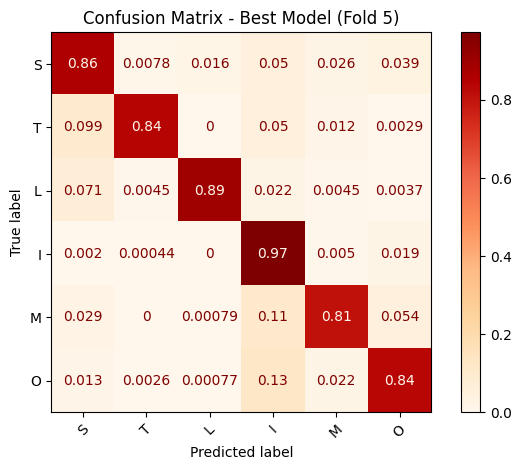

In [ ]:
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import classification_report, f1_score, matthews_corrcoef, accuracy_score, precision_score, recall_score

# Load best model
model = SPCNNClassifier(num_vhse_features, NUM_CLASSES).to(DEVICE)

model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
print(f"\nModel loaded from {MODEL_SAVE_PATH}")

model.eval()
test_loss = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        encoded_seq = batch['encoded_seq'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        # Compute loss using CRF
        loss = model(encoded_seq=encoded_seq, attention_mask=attention_mask, labels=labels)
        test_loss += loss.item()

        # Decode predictions using CRF
        predictions = model(encoded_seq=encoded_seq, attention_mask=attention_mask)

        # Collect valid tokens
        for pred_seq, label_seq, mask in zip(predictions, labels, attention_mask):
            for pred, true, is_valid in zip(pred_seq, label_seq, mask):
                if true.item() != -100 and is_valid.item() == 1:
                    all_preds.append(pred)
                    all_labels.append(true.item())

# Calculate metrics
print("\n" + "="*60)
print("Test Set Results")
print("="*60)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))

f1_weighted = f1_score(all_labels, all_preds, average='weighted')
f1_macro = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
mcc = matthews_corrcoef(all_labels, all_preds)
token_acc = accuracy_score(all_labels, all_preds)
seq_acc = sequence_level_accuracy(all_preds, all_labels, test_label_seqs)
seq_acc_only_sps = sequence_level_accuracy_only_sps(all_preds, all_labels, test_label_seqs)
avg_loss = test_loss / len(test_loader)

print(f"\nMetrics Summary:")
print(f"F1 Score (weighted): {f1_weighted:.4f}")
print(f"F1 Score (macro): {f1_macro:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Token-level Accuracy: {token_acc:.4f}")
print(f"Sequence Level Accuracy: {seq_acc:.4f}")
print(f"Sequence Level Accuracy (only SPs): {seq_acc_only_sps:.4f}")
print(f"Average test loss: {avg_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Store metrics for bar plot
test_metrics = {
    'mcc': mcc,
    'seq_acc': seq_acc,
    'seq_acc_only_sps': seq_acc_only_sps,
    'f1_weighted': f1_weighted,
    'f1_macro': f1_macro,
    'token_acc': token_acc,
    'precision': precision,
    'recall': recall,
    'avg_loss': avg_loss
}

In [ ]:
# Confusion Matrix (matching t5_lstm_cnn_6 style)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels, all_preds, labels=list(label_map.values()))
cm_relative = cm.astype("float") / cm.sum(axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_relative, display_labels=list(label_map.keys()))
disp.plot(cmap="OrRd", xticks_rotation=45)
plt.title("Confusion Matrix - VHSE LSTM-CNN")
plt.tight_layout()

# Save confusion matrix
cm_path = DATA_PATH / "outputs" / "confusion_matrix_vhse_lstm_cnn.png"
plt.savefig(cm_path, dpi=150)
print(f"\nConfusion matrix saved to: {cm_path}")
plt.show()

In [ ]:
# Bar Plot of Key Metrics (matching t5_lstm_cnn_6 style)
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

metrics_names = ['MCC', 'Seq Acc', 'Seq Acc (SP only)']
x = np.arange(len(metrics_names))
width = 0.5

# Get metric values from the test results
mean_values = [
    test_metrics['mcc'],
    test_metrics['seq_acc'],
    test_metrics['seq_acc_only_sps'],
]

# For single model evaluation (no folds), we show the values without error bars
# If you have fold results, you can add std error bars here

# Plot bars
bars = ax.bar(x, mean_values, width, color='steelblue', edgecolor='none', zorder=2)

# Styling (matching t5_lstm_cnn_6)
ax.set_facecolor('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('lightgray')
ax.spines['bottom'].set_color('lightgray')

# Horizontal lines
yticks = np.arange(0, 1.1, 0.2)
for y_tick in yticks:
    ax.axhline(y=y_tick, color='lightgray', linewidth=0.8, zorder=1)

ax.set_ylabel('Score', fontsize=16)
ax.set_title('Test Set Metrics - VHSE LSTM-CNN', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics_names, fontsize=16)
ax.set_ylim(0, 1.05)
ax.set_yticks(yticks)
ax.tick_params(axis='y', labelsize=16)

# Value labels on top of bars
for i, val in enumerate(mean_values):
    ax.text(i, val + 0.02, f'{val:.3f}', ha='center', va='bottom', fontsize=16)

plt.tight_layout()

# Save bar plot
bar_path = DATA_PATH / "outputs" / "best_metrics_bar_vhse_lstm_cnn.png"
plt.savefig(bar_path, dpi=150)
print(f"Bar plot saved to: {bar_path}")
plt.show()

In [ ]:
# Bar Plot with Cross-Validation Results (matching t5_lstm_cnn_6 plot_best_metrics_bar style)
# This uses the fold results from training to show mean ± std

import pickle

# Load training results to get fold metrics
losses_pickle_path = os.path.join(TRAIN_VAL_LOSSES_DATA_SAVE_PATH, "train_val_losses_vhse.pkl")

try:
    with open(losses_pickle_path, 'rb') as f:
        fold_results_loaded = pickle.load(f)
    
    # Check if we have per-fold best metrics
    if 'best_metrics' in fold_results_loaded:
        all_fold_metrics = fold_results_loaded['best_metrics']
        num_folds_loaded = fold_results_loaded['num_folds']
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        metrics_names = ['MCC', 'Seq Acc', 'Seq Acc (SP only)']
        x = np.arange(len(metrics_names))
        width = 0.5
        
        all_values = {
            'mcc': [m['mcc'] for m in all_fold_metrics],
            'seq_acc': [m['seq_acc'] for m in all_fold_metrics],
            'seq_acc_only_sps': [m['seq_acc_only_sps'] for m in all_fold_metrics],
        }
        
        mean_values = [
            np.mean(all_values['mcc']),
            np.mean(all_values['seq_acc']),
            np.mean(all_values['seq_acc_only_sps']),
        ]
        
        std_values = [
            np.std(all_values['mcc']),
            np.std(all_values['seq_acc']),
            np.std(all_values['seq_acc_only_sps']),
        ]
        
        # Plot bars with error bars
        ax.bar(x, mean_values, width, color='steelblue', edgecolor='none', zorder=2)
        ax.errorbar(x, mean_values, yerr=std_values, fmt='none',
                    ecolor='black', capsize=5, capthick=1.5, elinewidth=1.5, zorder=4)
        
        # Styling
        ax.set_facecolor('white')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_color('lightgray')
        ax.spines['bottom'].set_color('lightgray')
        
        yticks = np.arange(0, 1.1, 0.2)
        for y_tick in yticks:
            ax.axhline(y=y_tick, color='lightgray', linewidth=0.8, zorder=1)
        
        ax.set_ylabel('Score', fontsize=16)
        ax.set_title(f'Mean Validation Metrics Across {num_folds_loaded} Folds (Error bars: ± std)', fontsize=14)
        ax.set_xticks(x)
        ax.set_xticklabels(metrics_names, fontsize=16)
        ax.set_ylim(0, 1.05)
        ax.set_yticks(yticks)
        ax.tick_params(axis='y', labelsize=16)
        
        # Value labels with mean ± std
        max_yerr = max(std_values) if max(std_values) > 0 else 0.02
        for i, (val, std) in enumerate(zip(mean_values, std_values)):
            ax.text(i, val + max_yerr + 0.02, f'{val:.3f} ± {std:.3f}', ha='center', va='bottom', fontsize=14)
        
        plt.tight_layout()
        
        bar_cv_path = DATA_PATH / "outputs" / "cv_metrics_bar_vhse_lstm_cnn.png"
        plt.savefig(bar_cv_path, dpi=150)
        print(f"CV bar plot saved to: {bar_cv_path}")
        plt.show()
    else:
        print("No 'best_metrics' found in fold results. Run training with updated code to collect per-fold metrics.")
        print("Using test set metrics for the bar plot instead.")
        
except FileNotFoundError:
    print(f"Could not find {losses_pickle_path}")
    print("Run training first to generate fold results, or use the test set metrics bar plot above.")

In [ ]:
# Plot validation metrics across folds (matching t5_lstm_cnn_6 plot_training_metrics style)
import pickle

losses_pickle_path = os.path.join(TRAIN_VAL_LOSSES_DATA_SAVE_PATH, "train_val_losses_vhse.pkl")

try:
    with open(losses_pickle_path, 'rb') as f:
        fold_results_loaded = pickle.load(f)
    
    if all(key in fold_results_loaded for key in ['val_mcc', 'val_seq_acc', 'val_seq_accs_only_sps']):
        num_folds = fold_results_loaded['num_folds']
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Colors for each fold
        colors = plt.cm.tab10(np.linspace(0, 1, num_folds))
        
        # Plot 1: MCC
        ax = axes[0]
        for i, mccs in enumerate(fold_results_loaded['val_mcc']):
            epochs_range = range(1, len(mccs) + 1)
            ax.plot(epochs_range, mccs, color=colors[i], marker='^', markersize=3, label=f'Fold {i+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MCC')
        ax.set_title('Validation Matthews Correlation Coefficient')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Sequence-level Accuracy
        ax = axes[1]
        for i, seq_accs in enumerate(fold_results_loaded['val_seq_acc']):
            epochs_range = range(1, len(seq_accs) + 1)
            ax.plot(epochs_range, seq_accs, color=colors[i], marker='s', markersize=3, label=f'Fold {i+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Sequence Accuracy')
        ax.set_title('Validation Sequence-level Accuracy')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
        # Plot 3: Sequence-level Accuracy (SP sequences only)
        ax = axes[2]
        for i, seq_accs_sp in enumerate(fold_results_loaded['val_seq_accs_only_sps']):
            epochs_range = range(1, len(seq_accs_sp) + 1)
            ax.plot(epochs_range, seq_accs_sp, color=colors[i], marker='o', markersize=3, label=f'Fold {i+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Sequence Accuracy (SP only)')
        ax.set_title('Validation Seq Accuracy (SP sequences only)')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
        plt.suptitle('K-Fold Cross Validation Metrics (VHSE LSTM-CNN)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        metrics_plot_path = DATA_PATH / "outputs" / "6state_vhse_lstm_cnn_metrics_plot.png"
        plt.savefig(metrics_plot_path, dpi=150)
        print(f"Metrics plot saved to: {metrics_plot_path}")
        plt.show()
    else:
        print("Validation metrics (MCC, seq_acc, seq_acc_only_sps) not found in saved results.")
        print("Run training with updated code to collect per-epoch metrics.")
        
except FileNotFoundError:
    print(f"Could not find {losses_pickle_path}")
    print("Run training first to generate fold results.")

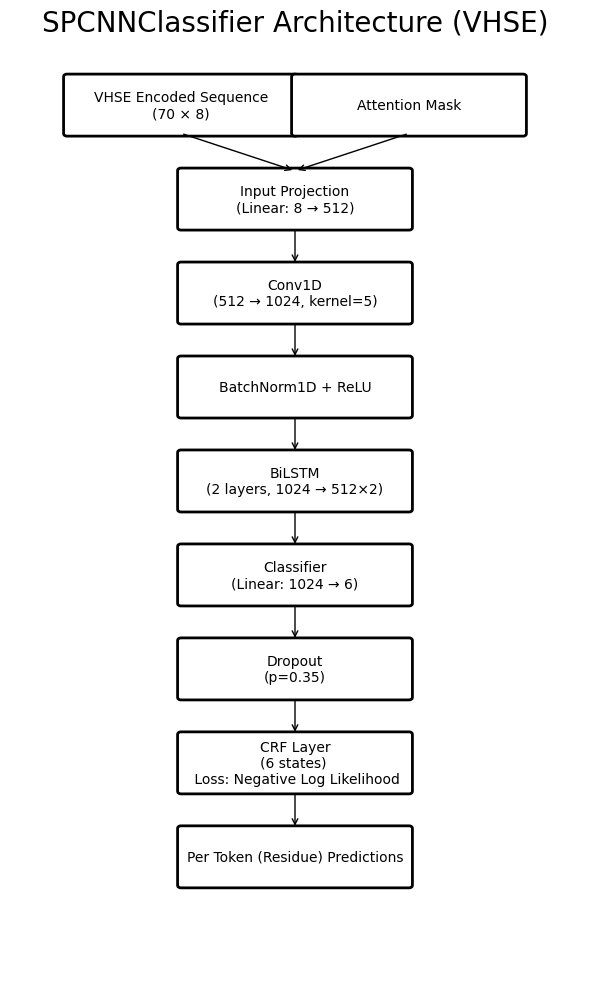

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def draw_vertical_model():
    fig, ax = plt.subplots(figsize=(6, 10))
    ax.axis('off')

    # Define blocks with (x, y)
    blocks = [
        ("VHSE Encoded Sequence\n(70 × 8)", 0.5, 9.0),  # Changed
        ("Attention Mask", 2.5, 9.0),
        ("Input Projection\n(Linear: 8 → 512)", 1.5, 8.0),  # Changed
        ("Conv1D\n(512 → 1024, kernel=5)", 1.5, 7.0),
        ("BatchNorm1D + ReLU", 1.5, 6.0),
        ("BiLSTM\n(2 layers, 1024 → 512×2)", 1.5, 5.0),
        ("Classifier\n(Linear: 1024 → 6)", 1.5, 4.0),
        ("Dropout\n(p=0.35)", 1.5, 3.0),
        ("CRF Layer\n(6 states) \n Loss: Negative Log Likelihood", 1.5, 2.0),
        ("Per Token (Residue) Predictions", 1.5, 1.0)
    ]

    box_width = 2.0
    box_height = 0.6

    # Draw blocks
    for label, x, y in blocks:
        rect = mpatches.FancyBboxPatch((x, y), box_width, box_height, boxstyle="round,pad=0.03",
                                       edgecolor='black', facecolor='white', linewidth=2)
        ax.add_patch(rect)
        ax.text(x + box_width / 2, y + box_height / 2, label, ha='center', va='center', fontsize=10)

    # Draw arrows
    for i in range(2, len(blocks) - 1):  # skip input sequence and mask arrows
        x1 = blocks[i][1] + box_width / 2
        y1 = blocks[i][2]
        y2 = blocks[i+1][2] + box_height
        ax.annotate('', xy=(x1, y2), xytext=(x1, y1),
                    arrowprops=dict(facecolor='black', arrowstyle='->'))

    # Draw arrows from inputs
    ax.annotate('', xy=(1.5 + box_width/2, 8.6), xytext=(0.5 + box_width/2, 9.0),
                arrowprops=dict(facecolor='black', arrowstyle='->'))
    ax.annotate('', xy=(1.5 + box_width/2, 8.6), xytext=(2.5 + box_width/2, 9.0),
                arrowprops=dict(facecolor='black', arrowstyle='->'))

    plt.title("SPCNNClassifier Architecture (VHSE)", fontsize=20)
    plt.ylim(0, 10)
    plt.xlim(0, 5)
    plt.tight_layout()
    plt.show()

draw_vertical_model()